In [2]:
#Importing the packages necessary

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import matplotlib.pyplot as plt
import cv2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from PIL import Image
import os,sys
print(os.listdir("../input"))
print(os.listdir('../input/imagetotest'))


# Any results you write to the current directory are saved as output.

['wildcam', 'iwildcam-2019-fgvc6', 'reduceddata', 'imagetotest']
['SM-wolverine-wildcam-1.jpg']


In [3]:
#loading the training and submission file
label_df = pd.read_csv('../input/iwildcam-2019-fgvc6/train.csv')
submission_df = pd.read_csv('../input/iwildcam-2019-fgvc6/sample_submission.csv')
label_df.head()



,category_id,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height
0,19,2011-05-13 23:43:18,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,1,5998cfa4-23d2-11e8-a6a3-ec086b02610b,33,Justin Brown,6f084ccc-5567-11e8-bc84-dca9047ef277,3,1024,747
1,19,2012-03-17 03:48:44,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,2,588a679f-23d2-11e8-a6a3-ec086b02610b,115,Justin Brown,6f12067d-5567-11e8-b3c0-dca9047ef277,3,1024,747
2,0,2014-05-11 11:56:46,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg,1,59279ce3-23d2-11e8-a6a3-ec086b02610b,96,Erin Boydston,6faa92d1-5567-11e8-b1ae-dca9047ef277,1,1024,747
3,0,2013-10-06 02:00:00,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg,1,5a2af4ab-23d2-11e8-a6a3-ec086b02610b,57,Erin Boydston,6f7d4702-5567-11e8-9e03-dca9047ef277,1,1024,747
4,0,2011-07-12 13:11:16,599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg,3,599fbd89-23d2-11e8-a6a3-ec086b02610b,46,Justin Brown,6f1728a1-5567-11e8-9be7-dca9047ef277,3,1024,747


In [ ]:
#
label_df = pd.read_csv('../input/train.csv')
submission_df = pd.read_csv('../input/sample_submission.csv')
label_df.head()

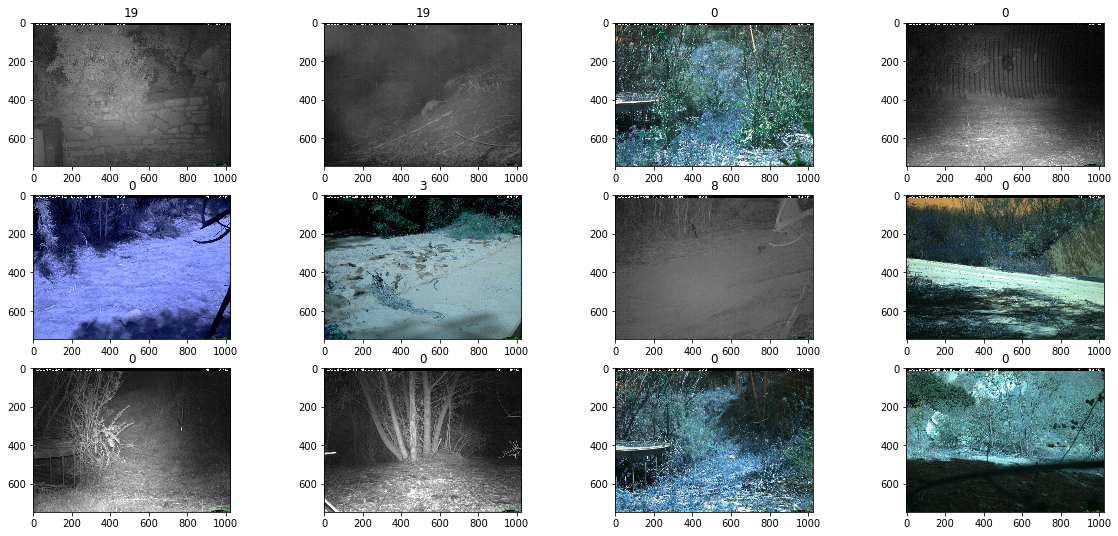

In [5]:
#to view the images
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 3*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'file_name']
        image_id = df.loc[i,'category_id']
        img = cv2.imread(f'../input/iwildcam-2019-fgvc6/train_images/{image_path}')
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)

display_samples(label_df)

In [ ]:
#a function to reduce the image size
def pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        width = ((t,b), (l,r), (0, 0))
    else:
        width = ((t,b), (l,r))
    return pad_width

def pad_and_resize(img_path, dataset, pad=False, desired_size=32):
    img = cv2.imread(f'../input/iwildcam-2019-fgvc6/{dataset}_images/{img_path}.jpg')
    
    if pad:
        width = pad_width(img, max(img.shape))
        padded = np.pad(img, width=width, mode='constant', constant_values=0)
    else:
        padded = img
    
    resized = cv2.resize(padded, (desired_size,)*2).astype('uint8')
    
    return resized


In [ ]:
img = cv2.imread(f'../input/imagetotest/SM-wolverine-wildcam-1.jpg')
resized = cv2.resize(img, (32,)*2).astype('uint8')

In [ ]:
#Resizing the images


train_resized = []
test_resized = []

for image_id in label_df['id']:
    train_resized.append(
        pad_and_resize(image_id, 'train')
    )

for image_id in submission_df['Id']:
    test_resized.append(
        pad_and_resize(image_id, 'test')
    )


In [ ]:
#to view the size of the reduced files and splitting train and test files.
X_train = np.stack(train_resized)
X_test = np.stack(test_resized)

target_dummies = pd.get_dummies(label_df['category_id'])
train_label = target_dummies.columns.values
y_train = target_dummies.values

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)


In [ ]:
#saving the reduces files
np.save('Resized_Xtrain.npy',X_train)
np.save('Resized_ytrain.npy',y_train)
np.save('Resized_Xtest.npy',X_test)


In [ ]:
#to view the contents in the wildcam-reduced directory
print(os.listdir('../input/reduceddata/wildcam-reduced'))

In [6]:
#loading the necessary reduced files
y_train = np.load('../input/reduceddata/wildcam-reduced/y_train.npy')
X_train = np.load('../input/reduceddata/wildcam-reduced/X_train.npy')
X_test = np.load('../input/reduceddata/wildcam-reduced/X_test.npy')

In [7]:
#to view the shapes
print('X_train shape is',X_train.shape)
print('X_test shape is', X_test.shape)
print('y_train.shape is',y_train.shape)

X_train shape is (196299, 32, 32, 3)
X_test shape is (153730, 32, 32, 3)
y_train.shape is (196299, 14)


In [8]:
#scaling the train and test data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [9]:
#importing the necessary keras libraries
from keras.applications import DenseNet121
from keras.layers import *
from keras.models import Sequential


Using TensorFlow backend.


In [10]:
#importing callbacks
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [ ]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_pred = self.model.predict(X_val)

        y_pred_cat = keras.utils.to_categorical(
            y_pred.argmax(axis=1),
            num_classes=14
        )
        _val_f1 = f1_score(y_val, y_pred_cat, average='macro')
        _val_recall = recall_score(y_val, y_pred_cat, average='macro')
        _val_precision = precision_score(y_val, y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" — val_precision: {_val_precision:.4f}"
               f" — val_recall: {_val_recall:.4f}"))

        return
    f1_metrics = Metrics()

In [12]:
#creating checkpoint 
import keras
from keras.callbacks import  ModelCheckpoint

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)


In [13]:
import keras
from keras.callbacks import  ModelCheckpoint

In [14]:
#importing the densenet model
dense_network = DenseNet121(input_shape = (32, 32, 3),include_top = False, classes = 1000)


Instructions for updating:
Colocations handled automatically by placer.
29089792/29084464 [==============================] - 1s 0us/step


In [15]:
#Defining the model
model = Sequential()
model.add(dense_network)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))

model.add(Dense(14, activation='softmax'))

model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1, 1, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                14350     
Total params: 7,051,854
Trainable params: 6,968,206
Non-trainable params: 83,648
_________________________________________________________________


In [16]:
#compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



In [17]:
#fitting the densenet model.
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=128,
    epochs=10,
    
    validation_split=0.2
)

Instructions for updating:
Use tf.cast instead.
Train on 157039 samples, validate on 39260 samples
Epoch 1/10
157039/157039 [==============================] - 197s 1ms/step - loss: 0.6625 - acc: 0.7911 - val_loss: 0.5769 - val_acc: 0.8169
Epoch 2/10
157039/157039 [==============================] - 171s 1ms/step - loss: 0.5015 - acc: 0.8381 - val_loss: 0.4711 - val_acc: 0.8498
Epoch 3/10
157039/157039 [==============================] - 171s 1ms/step - loss: 0.4170 - acc: 0.8638 - val_loss: 0.5246 - val_acc: 0.8267
Epoch 4/10
157039/157039 [==============================] - 170s 1ms/step - loss: 0.4461 - acc: 0.8552 - val_loss: 0.6738 - val_acc: 0.7855
Epoch 5/10
157039/157039 [==============================] - 171s 1ms/step - loss: 0.4493 - acc: 0.8527 - val_loss: 0.3886 - val_acc: 0.8709
Epoch 6/10
157039/157039 [==============================] - 170s 1ms/step - loss: 0.3526 - acc: 0.8824 - val_loss: 0.3580 - val_acc: 0.8800
Epoch 7/10
157039/157039 [==============================] - 1

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
# create model
model1 = Sequential()
model1.add(Conv2D(1, (3,3), input_shape=(32, 32, 3)))
model1.add(Conv2D(1, (3,3)))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Flatten())
model1.add(Dense(output_dim = 128, activation = 'relu'))
model1.add(Dense(output_dim = 14, activation = 'sigmoid'))
# summarize model
model1.summary()

In [ ]:
#compiling the model
model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#benchmark model's fitting
history = model1.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    callbacks=[f1_metrics],
    validation_split=0.2
)

In [ ]:
#Plotting the losses of train and test data.
fig = plt.subplots(figsize=(8,8))
plt.plot(history.history['loss'],color='g')
plt.plot(history.history['val_loss'],color='r')
plt.legend(['training','validation'])
plt.show()


In [ ]:
#Plotting the accuracy of train and test data.
fig = plt.subplots(figsize=(8,8))
plt.plot(history.history['acc'],color='g')
plt.plot(history.history['val_acc'],color='r')
plt.legend(['training','validation'])
plt.show()

In [18]:
#Predicting the submission file.
result = model.predict(X_test)
submission_df['Predicted'] = result.argmax(axis=1)
submission_df.head()


,Id,Predicted
0,b005e5b2-2c0b-11e9-bcad-06f10d5896c4,0
1,f2347cfe-2c11-11e9-bcad-06f10d5896c4,0
2,27cf8d26-2c0e-11e9-bcad-06f10d5896c4,0
3,f82f52c7-2c1d-11e9-bcad-06f10d5896c4,0
4,e133f50d-2c1c-11e9-bcad-06f10d5896c4,5


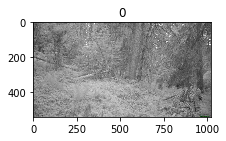

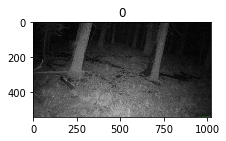

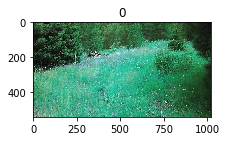

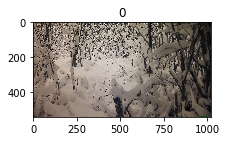

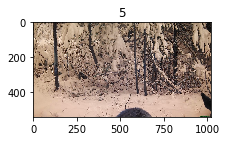

In [43]:
for i in range(5):
    fig=plt.figure(figsize=(11,8 ))
    img = cv2.imread(f'../input/iwildcam-2019-fgvc6/test_images/'+ submission_df.loc[i][0]+'.jpg')
    fig.add_subplot(4, 2, 2)
    plt.title(submission_df.loc[i][1])
    plt.imshow(img)

In [ ]:
#saving the file to csv.
submission_df.to_csv('final.csv',index=False)

In [95]:
import skimage as sk
from skimage import util

def random_noise(x):     
    x  = sk.util.random_noise(x)    
    return x

In [112]:

img = cv2.imread(f'../input/imagetotest/SM-wolverine-wildcam-1.jpg')
img2 = cv2.resize(img, (32,)*2).astype('uint8')
img = np.asarray([img2])
print(img.shape)

(1, 32, 32, 3)


In [91]:
result = model.predict(img)
result = result.argmax(axis=1)
print(result)

[13]


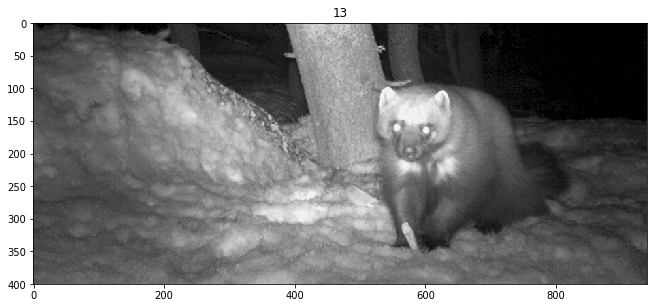

In [99]:
fig=plt.figure(figsize=(11,8 ))
img = cv2.imread(f'../input/imagetotest/SM-wolverine-wildcam-1.jpg')
plt.title(result[0])
plt.imshow(img)

In [111]:
img_n= random_noise(img)
result = model.predict(img_n)
result = result.argmax(axis=1)
print(result)

[1]


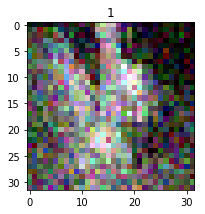

In [120]:
fig=plt.figure(figsize=(3,5 ))
plt.title(result[0])
plt.imshow(random_noise(img2))